In [1]:
import sys
sys.path.append('../src')

from mcmc_norm_learning.algorithm_1_v4 import to_tuple
from mcmc_norm_learning.rules_4 import get_log_prob
from pickle_wrapper import unpickle
import pandas as pd
import yaml
import tqdm
from numpy import log

In [2]:
with open("../params_nc.yaml", 'r') as fd:
    params = yaml.safe_load(fd)

In [3]:
num_obs=params["num_observations"]
true_norm=params['true_norm']['exp']

In [4]:
num_obs

100

In [5]:
base_path="../data_nc/exp_nc5/"
exp_paths=!ls $base_path

In [6]:
equiv_threshold = 0.00005

In [7]:
def get_num_viols(nc_obs):
    n_viols=0
    for obs in nc_obs:
        for action_pairs in zip(obs, obs[1:]):
            if action_pairs[0] in [(('pickup', 8), ('putdown', 8, '1')),(('pickup', 40), ('putdown', 40, '1'))]:
                if action_pairs[1][1][2] =='1': #not in obl zone
                    n_viols+=1
                elif action_pairs[1][1][2] =='3':
                    if action_pairs[1][1][1] not in [35,13]: #permission not applicable
                        n_viols+=1
    return (n_viols)

In [8]:
z1=pd.DataFrame()
for exp_path in exp_paths:
    temp=pd.DataFrame()
    #Add params
    obs_path=base_path+exp_path+"/obs.pickle"
    obs = unpickle(obs_path)
    temp["w_nc"] = [float(exp_path.split("w_nc=")[1].split(",")[0])]
    trial=1 if "trial" not in exp_path else exp_path.split(",trial=")[-1]
    temp["trial"]=[int(trial)]
    #Add violations
    n_viols=get_num_viols(obs)
    temp["violation_rate"]=[n_viols/num_obs]
    #Add lik,post
    prior_true=!grep "For True Norm" {base_path+exp_path+"/run.log"}
    lik_true=!grep "lik_no_norm" {base_path+exp_path+"/run.log"}
    post_true=float(prior_true[0].split("log_prior=")[-1]) + float(lik_true[0].split("lik_true_norm=")[1])
    temp["true_norm_posterior"]=[post_true]
    #Add if True Norm found in some chain
    if_true_norm=!grep "True norm in some chain(s)" {base_path+exp_path+"/chain_info.txt"}
    temp["if_true_norm_found"]= ["False" not in if_true_norm[0]]
    #Rank of True Norm if found as per posterior
    rank_df=pd.read_csv(base_path+exp_path+"/ranked_posteriors.csv",index_col=False)
    rank_true=rank_df.loc[rank_df.expression==str(to_tuple(true_norm))][["post_rank","log_posterior"]].values
    rank=int(rank_true[0][0]) if rank_true.shape[0]==1 else None
    temp["true_norm_rank_wrt_posterior"]= [rank]
    #Equivalent Norm
    log_lik=float(lik_true[0].split("lik_true_norm=")[1])
    rank_df["log_prior"]=rank_df["expression"\
                            ].apply(lambda x: get_log_prob("NORMS",eval(x.replace("(","[").replace(")","]"))))
    rank_df["log_lik"]=rank_df["log_posterior"]-rank_df["log_prior"]
    mask_equiv0=abs((rank_df["log_lik"]-log_lik)/log_lik)<=equiv_threshold
    rank_equiv=rank_df.loc[mask_equiv0]["post_rank"].min()
    temp["best_equiv_norm_rank_wrt_posterior"]= [rank_equiv]
    #max posterior found in chains
    rank_1=rank_df.loc[rank_df.post_rank==1]
    temp["max_posterior_in_chain"]= [rank_1.log_posterior.values[0]]
    temp["norm_wi_max_post"]= [rank_1.expression.values[0]]
    #chain summary
    chain_details = pd.read_csv(f"{base_path+exp_path}/chain_posteriors_nc.csv")
    n_chains1=chain_details.loc[chain_details.expression==str(true_norm)].chain_number.nunique()
    temp["#chains_wi_true_norm"]= [n_chains1]
    chain_max_min=chain_details.groupby(["chain_number"])[["log_posterior"]].agg(['min', 'max', 'mean', 'std'])
    n_chains2=(chain_max_min["log_posterior","max"]>post_true).sum()
    temp["#chains_wi_post_gt_true_norm"]= [n_chains2]
    #Posterior Estimation
    n=params["n"]
    top_norms=chain_details.loc[chain_details.chain_pos>2*n\
                           ].groupby(["expression"]).agg({"log_posterior":["mean","count"]})
    top_norms["chain_rank"]=top_norms[[('log_posterior', 'count')]].rank(method='dense',ascending=False)
    top_norms.sort_values(by=["chain_rank"],inplace=True)
    #print (top_norms.head(1))
    rank_true_wi_freq=top_norms.iloc[top_norms.index==str(true_norm)]["chain_rank"].values
    rank_true_wi_freq = float(rank_true_wi_freq[0]) if rank_true_wi_freq.size>0 else None
    temp["rank_true_wi_freq"]= [rank_true_wi_freq]
    post_norm_top=top_norms.loc[top_norms.chain_rank==1]["log_posterior","mean"].values
    post_norm_top = post_norm_top[0] if post_norm_top.size>0 else None
    temp["posterior_norm_top"]= [post_norm_top]
    #Num equivalent norms in posterior
    top_norms["log_prior"]=top_norms.index.to_series().apply(lambda x: get_log_prob("NORMS",eval(x)))[0]
    top_norms["log_lik"]=top_norms[('log_posterior',  'mean')]-top_norms["log_prior"]
    mask_equiv=abs((top_norms["log_lik"]-log_lik)/log_lik)<=equiv_threshold
    n_equiv=mask_equiv.sum()
    temp["total_equiv_norms_in_top_norms"]= [n_equiv]
    n_equiv_20=mask_equiv[:20].sum()
    temp["total_equiv_norms_in_top_20_norms"] = [n_equiv_20]
    best_equiv_norm_rank=top_norms.loc[mask_equiv]["chain_rank"].min()
    temp["best_equiv_norm_rank_wi_freq"]= [best_equiv_norm_rank]
    best_equiv_norm=eval(top_norms.loc[mask_equiv].index[0]) if n_equiv>0 else None
    temp["best_equiv_norm"]= [best_equiv_norm]
    z1=z1.append(temp)

In [9]:
z1.columns

Index(['w_nc', 'trial', 'violation_rate', 'true_norm_posterior',
       'if_true_norm_found', 'true_norm_rank_wrt_posterior',
       'best_equiv_norm_rank_wrt_posterior', 'max_posterior_in_chain',
       'norm_wi_max_post', '#chains_wi_true_norm',
       '#chains_wi_post_gt_true_norm', 'rank_true_wi_freq',
       'posterior_norm_top', 'total_equiv_norms_in_top_norms',
       'total_equiv_norms_in_top_20_norms', 'best_equiv_norm_rank_wi_freq',
       'best_equiv_norm'],
      dtype='object')

In [10]:
z1["if_equiv_norm_found"]=z1["total_equiv_norms_in_top_norms"]>0

z1["if_true_or_equiv_norm_found"]=z1["if_equiv_norm_found"] | z1["if_true_norm_found"]

z1["true_post/max_post"]=z1["true_norm_posterior"]/z1["max_posterior_in_chain"]
z1["%chains_wi_true_norm"]=z1["#chains_wi_true_norm"]/10
z1["%chains_wi_post_gt_true_norm"]=z1["#chains_wi_post_gt_true_norm"]/10

z1["expected_violation_rate"]=z1["w_nc"]*108/243

In [11]:
z1["chk"]=z1["violation_rate"]/z1["expected_violation_rate"]

In [12]:
z1["min_true_or_equiv_rank_wi_posterior"]=z1[["true_norm_rank_wrt_posterior",\
                                              "best_equiv_norm_rank_wrt_posterior"]].min(axis=1)
z1["min_true_or_equiv_rank_wi_freq"]=z1[["rank_true_wi_freq",\
                                              "best_equiv_norm_rank_wi_freq"]].min(axis=1)

### Summary

In [13]:
print ("%trials where true norms found: {:.2%}".format(z1["if_true_norm_found"].mean()))
print ("%trials where equiv norms found: {:.2%}".format(z1["if_equiv_norm_found"].mean()))
print ("%trials where true/equiv norms found: {:.2%}".format(z1["if_true_or_equiv_norm_found"].mean()))

%trials where true norms found: 88.89%
%trials where equiv norms found: 41.67%
%trials where true/equiv norms found: 88.89%


### Where are neither True nor equivalent Norms found ?

In [14]:
z1["true_norm_rank_wrt_posterior"]=pd.to_numeric(z1["true_norm_rank_wrt_posterior"])
z1["rank_true_wi_freq"]=pd.to_numeric(z1["rank_true_wi_freq"])

In [15]:
z1.loc[z1.w_nc==0.25][["true_norm_rank_wrt_posterior","best_equiv_norm_rank_wrt_posterior",\
                      "min_true_or_equiv_rank_wi_posterior"]]

,true_norm_rank_wrt_posterior,best_equiv_norm_rank_wrt_posterior,min_true_or_equiv_rank_wi_posterior
0,NaN,NaN,NaN
0,9.0,9.0,9.0
0,NaN,NaN,NaN


In [31]:
res1=z1.groupby(["w_nc"]).agg({"trial":["count"],"true_norm_rank_wrt_posterior":"mean",\
                          "best_equiv_norm_rank_wrt_posterior":"mean","min_true_or_equiv_rank_wi_posterior":"mean"})
res1.to_csv("./exp5_results_wrt_posterior.csv")
res1

,trial,true_norm_rank_wrt_posterior,best_equiv_norm_rank_wrt_posterior,min_true_or_equiv_rank_wi_posterior
,count,mean,mean,mean
w_nc,,,,
0.00,3,1.000000,1.000000,1.000000
0.05,3,1.000000,1.000000,1.000000
0.10,3,1.000000,1.000000,1.000000
0.15,3,1.000000,1.000000,1.000000
0.20,3,1.000000,1.000000,1.000000
0.25,3,9.000000,9.000000,9.000000
0.30,3,1.500000,46.333333,46.333333
0.35,3,3.000000,3.000000,3.000000


In [32]:
res2=z1.groupby(["w_nc"]).agg({"trial":["count"],"rank_true_wi_freq":"mean","best_equiv_norm_rank_wi_freq":"mean",\
                         "min_true_or_equiv_rank_wi_freq":"mean"})
res2.to_csv("./exp5_results_wrt_freq.csv")
res2

,trial,rank_true_wi_freq,best_equiv_norm_rank_wi_freq,min_true_or_equiv_rank_wi_freq
,count,mean,mean,mean
w_nc,,,,
0.00,3,4.000000,1.0,3.333333
0.05,3,2.000000,1.0,1.333333
0.10,3,1.000000,1.0,1.000000
0.15,3,4.000000,1.0,4.000000
0.20,3,2.000000,1.0,1.000000
0.25,3,9.000000,NaN,9.000000
0.30,3,1.500000,1.0,1.000000
0.35,3,23.000000,NaN,23.000000


In [33]:
res3=z1.groupby(["w_nc"]).agg({"if_true_or_equiv_norm_found":"mean","trial":"count",\
                                    "true_norm_posterior":"mean"})
res3.to_csv("./avg_posterior_vs_w_nc.csv")
res3

,if_true_or_equiv_norm_found,trial,true_norm_posterior
w_nc,,,
0.00,1.000000,3,-530.877460
0.05,1.000000,3,-534.182300
0.10,1.000000,3,-532.936189
0.15,1.000000,3,-533.399935
0.20,1.000000,3,-538.238127
0.25,0.333333,3,-548.324573
0.30,0.666667,3,-553.558285
0.35,1.000000,3,-552.393750
0.40,1.000000,3,-548.692496


trial
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

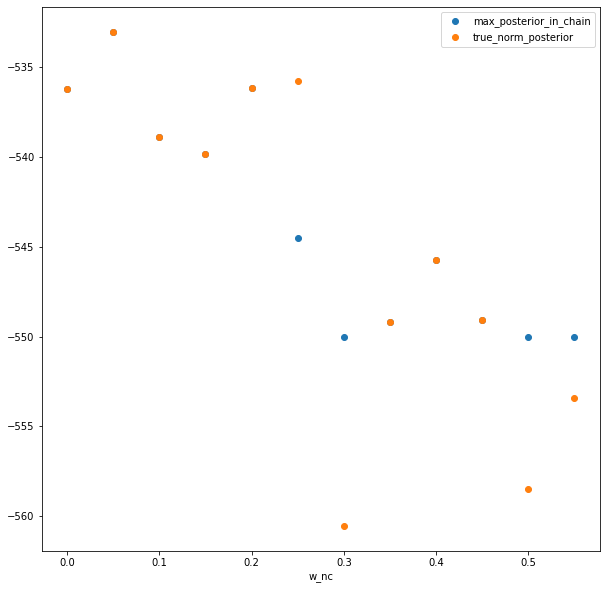

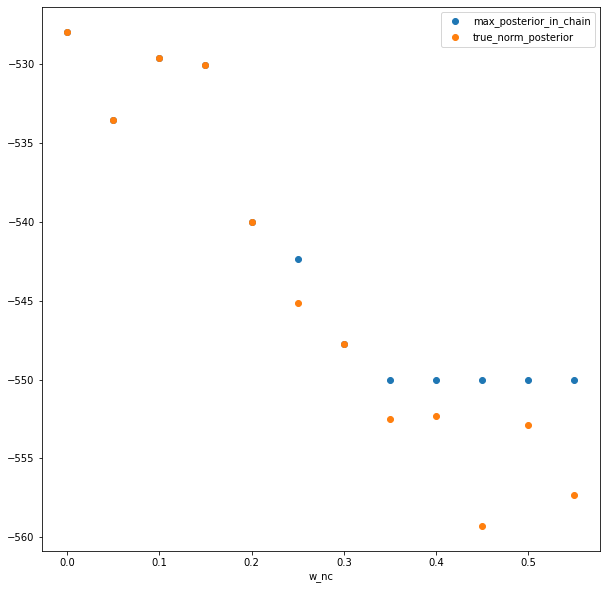

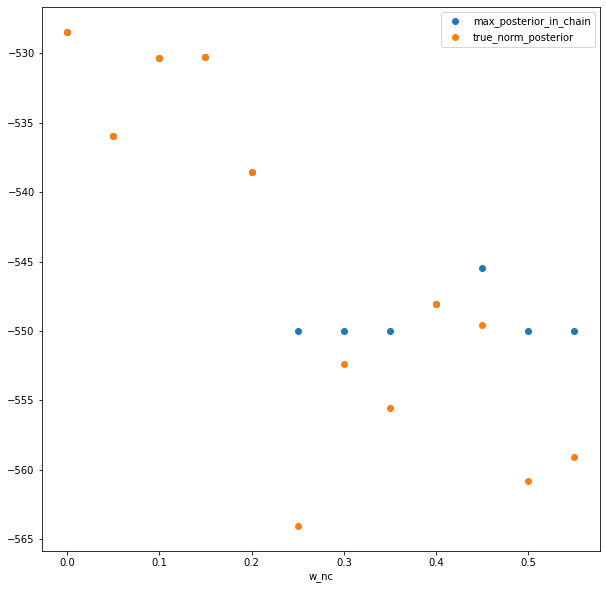

In [176]:
import matplotlib.pyplot as plt
z1.groupby("trial").plot(x="w_nc",y=["max_posterior_in_chain","true_norm_posterior"],\
        marker="o",kind = 'line',ls="none",figsize = (10,10),subplots=False)

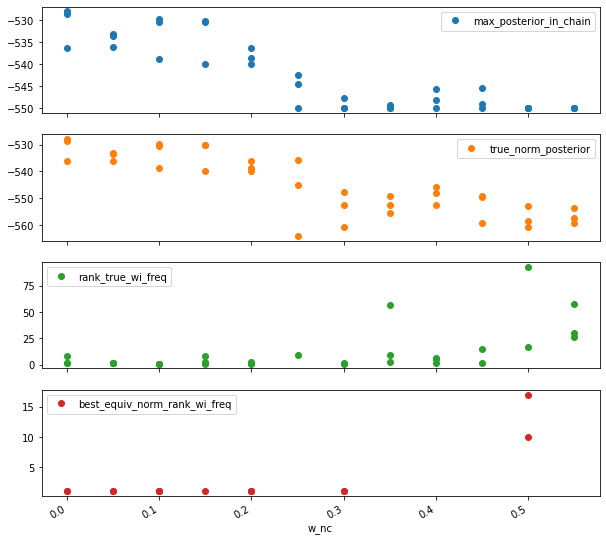

In [34]:
import matplotlib.pyplot as plt
z1.plot(x="w_nc",y=["max_posterior_in_chain","true_norm_posterior",\
                   "rank_true_wi_freq","best_equiv_norm_rank_wi_freq"],subplots=True,\
        marker="o",kind = 'line',ls="none",figsize = (10,10))
plt.savefig("./exp_5_summarised_results.jpg")
#z1.plot(x="chk",y="true_norm_posterior",kind="scatter")

In [266]:
z1_copy=z1.copy()
z1_copy
import seaborn as sns

In [151]:
z1_chk=pd.DataFrame()
z1_chk_a=z1_copy[["w_nc","trial","max_posterior_in_chain"]]
z1_chk_a.columns=["w_nc","trial","y"]
z1_chk_a["y_type"]="max_posterior_in_chain"

z1_chk_b=z1_copy[["w_nc","trial","true_norm_posterior"]]
z1_chk_b.columns=["w_nc","trial","y"]
z1_chk_b["y_type"]="true_norm_posterior"

z1_chk=z1_chk_a.append(z1_chk_b)

<ipython-input-151-dfd0a14150fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z1_chk_a["y_type"]="max_posterior_in_chain"
<ipython-input-151-dfd0a14150fa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z1_chk_b["y_type"]="true_norm_posterior"


/Users/ashish1610dhiman/data_projects/otago_norm_learning/mcmc/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ashish1610dhiman/data_projects/otago_norm_learning/mcmc/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ashish1610dhiman/data_projects/otago_norm_learning/mcmc/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ashish1610dhiman/data_projects/otago_norm_learning/mcmc/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 66.7% of the points cannot be p

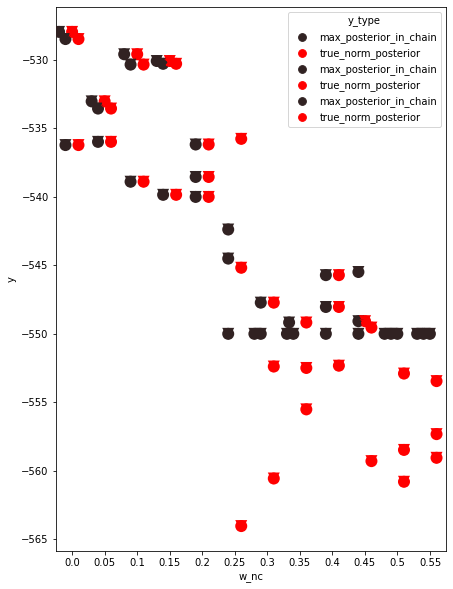

In [155]:
fig, axs = plt.subplots(1,1,figsize=(7,10))
groups = z1_chk.groupby(["trial"])

markers = ("o","v","*")
for (name, group), marker in zip(groups, markers):
    sns.swarmplot(x="w_nc",hue="y_type", y="y", data=z1_chk\
                  ,color="r",s=12,dodge=True,ax=axs,marker=marker)

<AxesSubplot:xlabel='w_nc', ylabel='true_norm_posterior'>

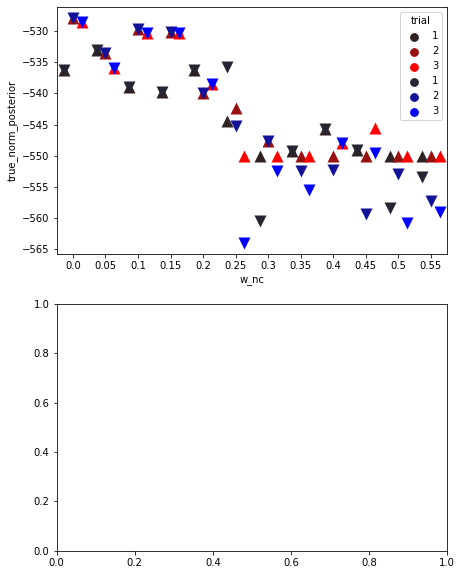

In [141]:
fig, axs = plt.subplots(2,1,figsize=(7,10))
sns.swarmplot(x="w_nc",hue="trial", y="max_posterior_in_chain", data=z1,
              marker="^",color="r",s=12,dodge=True,ax=axs[0])
sns.swarmplot(x="w_nc",hue="trial", y="true_norm_posterior", data=z1,
              marker="v",color="b",s=12,dodge=True,ax=axs[0])

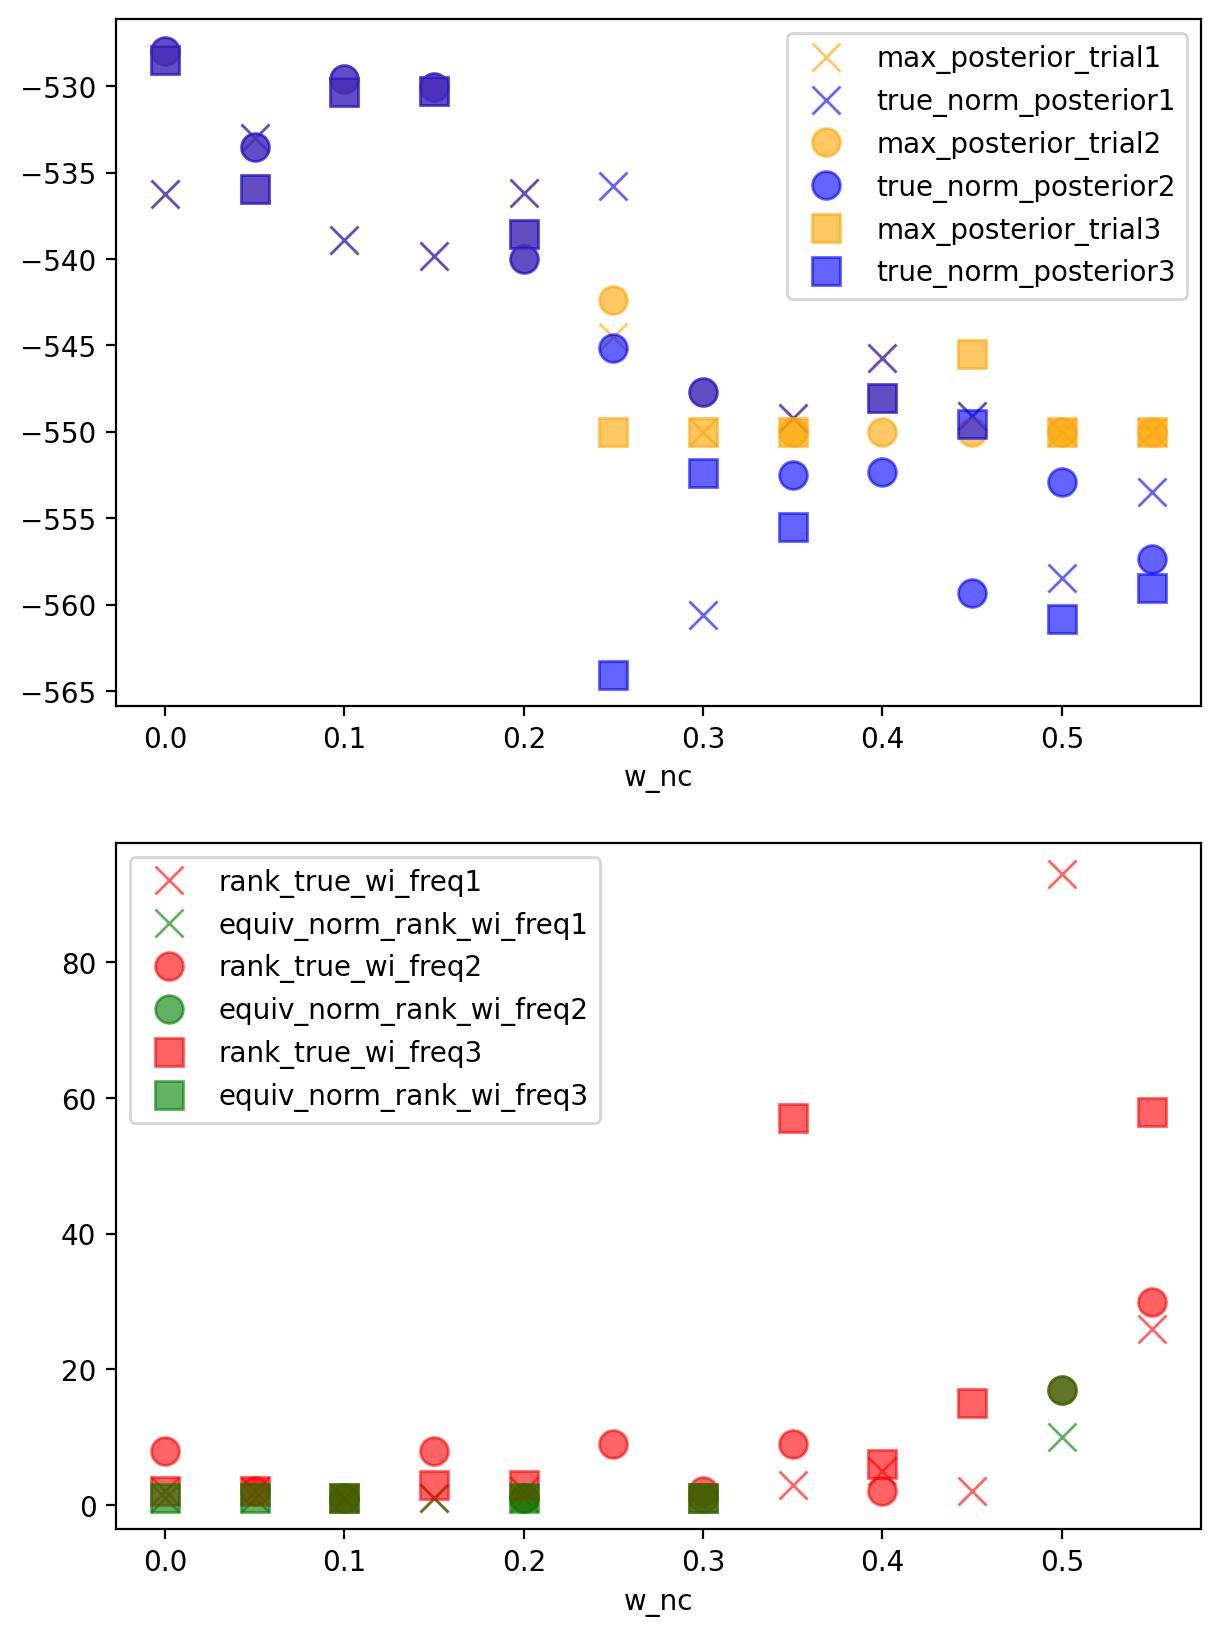

In [220]:
fig, axs = plt.subplots(2,1,figsize=(7,10),dpi=200)
groups = z1.groupby(["trial"])

markers = ("x","o","s")
for (name, group), marker in zip(groups, markers):
    ad_label=[f"max_posterior_trial{name}",f"true_norm_posterior{name}"]
    ad_label2=[f"rank_true_wi_freq{name}",f"equiv_norm_rank_wi_freq{name}"]
#     sns.swarmplot(x="w_nc", y="max_posterior_in_chain", data=group,ax=axs[0],\
#                   marker=marker,s=12,dodge=True,color="b",alpha=1)
#     sns.swarmplot(x="w_nc", y="true_norm_posterior", data=group,ax=axs[0],\
#                   marker=marker,s=12,dodge=True,color="g",alpha=1)
#     sns.catplot(data=group,x='w_nc', y="max_posterior_in_chain",ax=axs[0],label=ad_label[0],markers=marker,
#                   ls="",dodge=0.1)
#     sns.catplot(data=group,x='w_nc', y="true_norm_posterior",ax=axs[0],label=ad_label[1],\
#                   markers=marker,ls="",dodge=0.1)
    g_trial1=group.plot(x="w_nc",y=["max_posterior_in_chain"],label=[ad_label[0]],\
                        subplots=False,linestyle='',c="orange",marker=marker, ms=10,ax=axs[0],alpha=0.61)
    g_trial2=group.plot(x="w_nc",y=["true_norm_posterior"],subplots=False,\
        linestyle='',marker=marker, ms=10,ax=axs[0],label=[ad_label[1]],c="blue",alpha=0.61)
    axs[0].legend()
    g_trial1=group.plot(x="w_nc",y=["rank_true_wi_freq"],label=[ad_label2[0]],subplots=False,\
        linestyle='',marker=marker, ms=10,ax=axs[1],c="red",alpha=0.61)
    g_trial2=group.plot(x="w_nc",y=["best_equiv_norm_rank_wi_freq"],subplots=False,\
        linestyle='',marker=marker, ms=10,ax=axs[1],label=[ad_label2[1]],c="green",alpha=0.61)
    axs[1].legend()
plt.savefig("exp5_postrior_plot.jpg")  

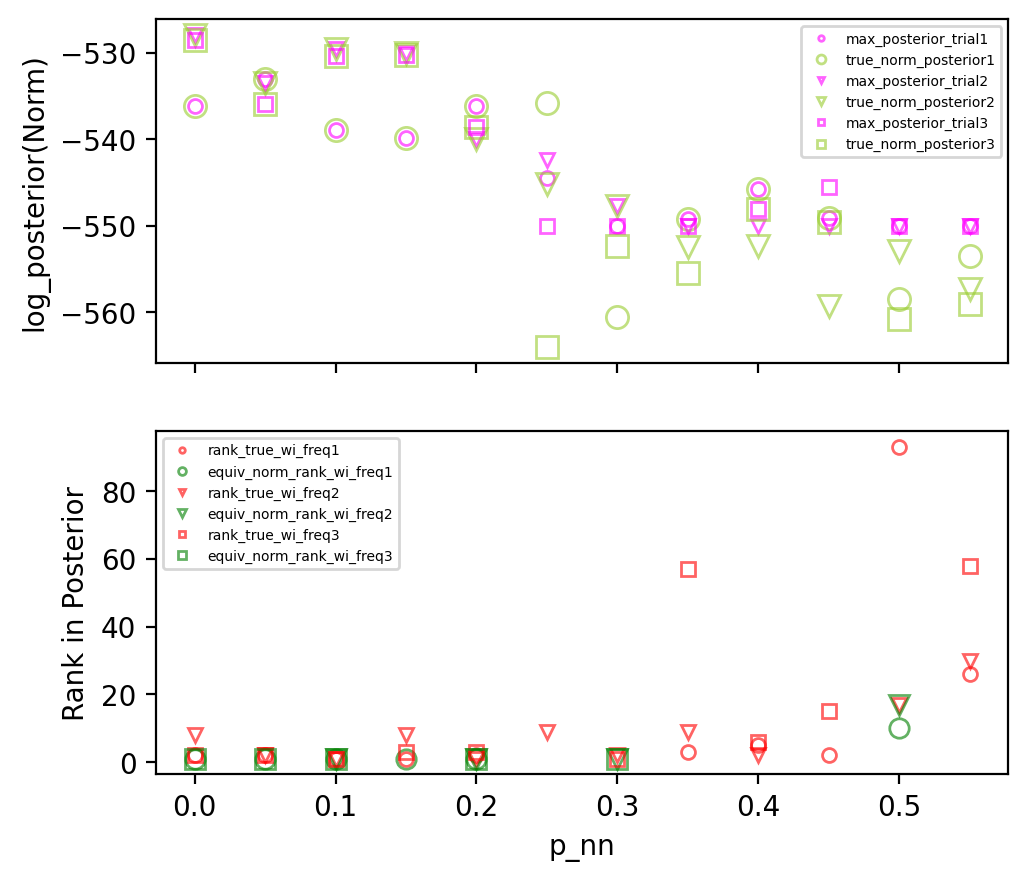

In [284]:
z1_copy=z1_copy.rename(columns={"w_nc":"p_nn"})
fig, axs = plt.subplots(2,1,figsize=(5.5,5),dpi=200,sharex=True)
#z1_copy["max_posterior_in_chain"]=z1_copy["max_posterior_in_chain"]
groups = z1_copy.groupby(["trial"])

markers = ("o","v","s")
for (name, group), marker in zip(groups, markers):
    ad_label=[f"max_posterior_trial{name}",f"true_norm_posterior{name}"]
    ad_label2=[f"rank_true_wi_freq{name}",f"equiv_norm_rank_wi_freq{name}"]
    g_trial1=group.plot(x="p_nn",y=["max_posterior_in_chain"],label=[ad_label[0]],markerfacecolor='none',\
                        subplots=False,linestyle='',c="magenta",marker=marker, ms=5,ax=axs[0],alpha=0.61)
    g_trial2=group.plot(x="p_nn",y=["true_norm_posterior"],subplots=False,markerfacecolor='none',\
        linestyle='',marker=marker, ms=8,ax=axs[0],label=[ad_label[1]],c="yellowgreen",alpha=0.61)
    axs[0].legend(prop={"size":5},markerscale=0.4)
    axs[0].set_ylabel("log_posterior(Norm)")
    #lgnd0.legendHandles[0]._sizes = [2]
    g_trial1=group.plot(x="p_nn",y=["rank_true_wi_freq"],label=[ad_label2[0]],subplots=False,markerfacecolor='none',\
        linestyle='',marker=marker, ms=5,ax=axs[1],c="red",alpha=0.61)
    g_trial2=group.plot(x="p_nn",y=["best_equiv_norm_rank_wi_freq"],subplots=False,markerfacecolor='none',\
        linestyle='',marker=marker, ms=7,ax=axs[1],label=[ad_label2[1]],c="green",alpha=0.61)
    axs[1].legend(prop={"size":5},markerscale=0.4)
    axs[1].set_ylabel("Rank in Posterior")
plt.savefig("exp5_posetrior_plot_p_nn.jpg")  

In [22]:
108/243*0.3,rank_true_wi_freq","best_equiv_norm_rank_wi_freq"

0.13333333333333333

In [24]:
z1.groupby(["w_nc"]).agg({"trial":"count","if_true_norm_found":[("mean")],"if_equiv_norm_found":"mean",\
                          "if_true_or_equiv_norm_found":"mean","true_norm_posterior":"mean",\
                          "true_post/max_post":"mean","%chains_wi_true_norm":"mean"})

,trial,if_true_norm_found,if_equiv_norm_found,if_true_or_equiv_norm_found,true_norm_posterior,true_post/max_post,%chains_wi_true_norm
,count,mean,mean,mean,mean,mean,mean
w_nc,,,,,,,
0.00,3,1.000000,0.666667,1.000000,-530.877460,1.000000,0.366667
0.05,3,1.000000,0.666667,1.000000,-534.182300,1.000000,0.533333
0.10,3,1.000000,1.000000,1.000000,-532.936189,1.000000,0.500000
0.15,3,1.000000,0.333333,1.000000,-533.399935,1.000000,0.333333
0.20,3,1.000000,1.000000,1.000000,-538.238127,1.000000,0.566667
0.25,3,0.333333,0.000000,0.333333,-548.324573,1.004874,0.100000
0.30,3,0.666667,0.666667,0.666667,-553.558285,1.007851,0.433333
0.35,3,1.000000,0.000000,1.000000,-552.393750,1.004854,0.166667


In [27]:
z1.to_csv("./exp5_results_raw_collated.csv")

In [285]:
z1[["w_nc","trial","norm_wi_max_post","max_posterior_in_chain","true_norm_posterior"]\
  ].to_csv("norms_wi_highest_posterior.csv")

In [23]:
z1.groupby(["w_nc","violation_rate"]).agg({"trial":"count","if_true_or_equiv_norm_found":"mean"})

trial  if_true_or_equiv_norm_found
w_nc violation_rate                                    
0.00 0.00                3                         True
0.05 0.02                1                         True
     0.03                2                         True
0.10 0.01                2                         True
     0.03                1                         True
0.15 0.00                1                         True
     0.01                1                         True
     0.07                1                         True
0.20 0.02                1                         True
     0.03                1                         True
     0.04                1                         True
0.25 0.04                1                        False
     0.06                1                         True
     0.15                1                        False
0.30 0.07                1                         True
     0.12                1                         True
     0.14                1                        False
0.35 0.12                1                         True
     0.13                1                         True
     0.18                1                         True
0.40 0.08                1                         True
     0.09                1                         True
     0.12                1                         True
0.45 0.06                1                         True
     0.10                1                         True
     0.15                1                         True
0.50 0.14                1                         True
     0.16                1                        False
     0.18                1                         True
0.55 0.11                1                         True
     0.12                1                         True
     0.22                1                         True